# Team number:5D12
# Sem 5, D Division, SOCSE
# Title:Building insurance claim predition.(5DMACP08)
# Problem statement: To predict if a building will have an insurance claim during a certain period.
# Team:
# Suyog Bhat(TL).................Roll no-251  USN-01fe17bcs225
# Shreyas katagi..................Roll no-222  USN-01FE17BCS196
# Shrinivas Miskin...............Roll No-223  USN-01FE17BCS197
# Shreevardhan Kamble....Roll No-224  USN-01FE17BCS198 
# Link: https://challengedata.ens.fr/challenges/19

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [176]:
#reading input file
train_users = pd.read_csv('./X_train.csv')
test_users=pd.read_csv('./X_test.csv')
users=pd.concat((train_users, test_users), axis = 0, ignore_index = True, sort = False)

In [177]:
print("In total we have",users.shape[0], "users.")

In total we have 13641 users.


In [178]:
#NULL values
users_nan = (users.isnull().sum() / users.shape[0]) * 100
users_nan[users_nan > 0]

superficief     1.180265
ft_22_categ    12.007917
Insee           1.128949
dtype: float64

Data transformation

In [179]:
#convert EXPO int float replacing , by .
users['EXPO'] = [x.replace(',', '.') for x in users['EXPO']]
users['EXPO'] = users['EXPO'].astype(float)
#EXPO atribute converted into float values

In [180]:
#zero replaced by minimum expo i.e 0.02 because minimum value in dataset
users.loc[users.EXPO==0,'EXPO']=0.020
users['EXPO'].fillna(users['EXPO'].mean(),inplace=True)
users['superficief'].fillna(users['superficief'].mean(),inplace=True)
users.EXPO.head()

0    1.000000
1    1.000000
2    1.000000
3    0.246575
4    1.000000
Name: EXPO, dtype: float64

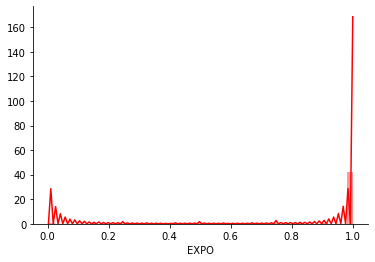

In [201]:
#period of insurance distribution
sns.distplot(users.EXPO.dropna(), color='red')
plt.xlabel('EXPO')
sns.despine()
#starts with 0 which is impossible case needs to be handled

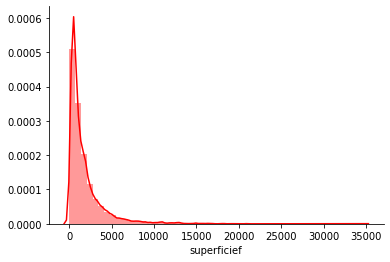

In [181]:
#area and count plot
sns.distplot(users.superficief.dropna(), color='red')
plt.xlabel('superficief')
sns.despine()
#extends upto 35000 which is hard to believe needs to be handled

In [182]:
#less than 5 m^2 seems impossible
users.loc[users.superficief<5,'superficief']=5
users.loc[users.superficief>10000,'superficief']=10000
#all value greater than 10000 are considered as 10000

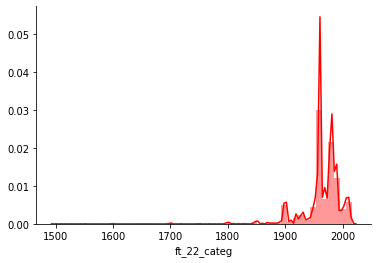

In [183]:
#year of construction
sns.distplot(users.ft_22_categ.dropna(), color='red')
plt.xlabel('ft_22_categ')
sns.despine()
#starts from 1500 which looks like monument but needs to be modified

In [184]:
#fixing null values of ft_22_categ and superficief
users['ft_22_categ'].fillna(users['ft_22_categ'].mode()[0],inplace=True)
users['Insee'].fillna(-1, inplace = True)
#most building constructed year seems right replacement for NaN
#insee data is replaced by global constant

In [185]:
#combining target values
res= pd.read_csv('./y_train_saegPGl.csv')
users['target']=res['target']

# external data

In [186]:
#reading external data
ins=pd.read_csv('./extinsee.csv')
ins.shape[0]

36742

In [187]:
#merding insee codes
mer=pd.merge(users,ins,on='Insee',how='left')
mer.columns

Index(['n', 'Identifiant', 'ft_2_categ', 'EXPO', 'ft_4_categ', 'ft_5_categ',
       'ft_6_categ', 'ft_7_categ', 'ft_8_categ', 'ft_9_categ', 'ft_10_categ',
       'ft_11_categ', 'ft_12_categ', 'ft_13_categ', 'ft_14_categ',
       'ft_15_categ', 'ft_16_categ', 'ft_17_categ', 'ft_18_categ',
       'ft_19_categ', 'superficief', 'ft_21_categ', 'ft_22_categ',
       'ft_23_categ', 'ft_24_categ', 'Insee', 'target', 'Commune',
       'Department', 'Reion', 'Altitude Moyenne', 'Superficie'],
      dtype='object')

In [188]:
#unnecessary columns in insee data
mer.drop('Commune',axis=1,inplace=True)
mer.drop('Reion',axis=1,inplace=True)
mer.drop('Altitude Moyenne',axis=1,inplace=True)
mer.drop('Superficie',axis=1,inplace=True)

In [189]:
#target variable is extracted
claimed=users.loc[users['target']==1]

one hot encoding

In [190]:
encoded_users=mer
# Own implementation of One Hot Encoding - Data Transformation
def convert_to_binary(df, column_to_convert):
    categories = list(df[column_to_convert].drop_duplicates())

    for category in categories:
        cat_name = str(category).replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").replace("-", "").lower()
        col_name = column_to_convert[:5] + '_' + cat_name[:10]
        df[col_name] = 0
        df.loc[(df[column_to_convert] == category), col_name] = 1

    return df

# One Hot Encoding
print("One Hot Encoding categorical data...")
columns_to_convert = ['ft_4_categ','ft_5_categ', 'ft_6_categ', 'ft_7_categ', 'ft_8_categ', 'ft_9_categ',
       'ft_10_categ', 'ft_11_categ', 'ft_12_categ', 'ft_13_categ',
       'ft_14_categ', 'ft_15_categ', 'ft_16_categ', 'ft_17_categ',
       'ft_18_categ','ft_19_categ','ft_21_categ','ft_23_categ','ft_24_categ','Department']

for column in columns_to_convert:
    encoded_users = convert_to_binary(df=encoded_users, column_to_convert=column)
    encoded_users.drop(column, axis=1, inplace=True)
print("One Hot Encoding categorical data...completed")

One Hot Encoding categorical data...
One Hot Encoding categorical data...completed


data reduction and cleaning

In [191]:
#dropping ID and row number
train=encoded_users
train.drop('n',axis=1,inplace=True)
train.set_index('Identifiant', inplace=True)

In [192]:
#train test seperation
test=train[train['target'].isnull()]
train=train[np.isfinite(train['target'])]

In [193]:
#label encoding of target variable and dropping prev target column
from sklearn.preprocessing import LabelEncoder

id_train= train.index.values
labels = train['target']

le = LabelEncoder()
y = le.fit_transform(labels)

x = train.drop('target', axis=1, inplace=False)
x = x.drop('Insee', axis=1, inplace=False)

In [195]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [196]:
#assigning test df to test
features_train=x
labels_train=y
features_test=test

In [197]:
#model construction (XG Boost)
model = XGBClassifier()
model.fit(features_train, labels_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [198]:
#predictions
cols = x.columns.tolist()
features_test=features_test[cols]
y_pred = model.predict(features_test)
predictions = y_pred

In [207]:
##Training data tested 7:3
features_train1, features_test1, labels_train1, labels_test1 = train_test_split(x, y, test_size=0.3, random_state=42)
model1 = XGBClassifier()
model1.fit(features_train1, labels_train1)
y_pred1 = model1.predict(features_test1)
predictions1 = y_pred1
predictions1

accuracy = accuracy_score(labels_test1, predictions1)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.53%


In [200]:
#output file for submission
test=pd.read_csv('./X_test1.csv')
test['target']=predictions
test.to_csv('y_test.csv')
print("output file generated..!")

output file generated..!
